# Reinforcement Learning Lab: Bandits

In this lab, you take on the role of a data scientist at **NewsNet**, a company that personalizes news recommendations. Every time a user logs in, you observe their profile (**context**) and recommend one of several articles. The user may click (**reward = 1**) or ignore (**reward = 0**).

You must learn to make better decisions over time by balancing **exploration** and **exploitation**.  
This is modeled using **bandit algorithms**.

---

## Part 1: Multi-Armed Bandits
In this part, you will start with the classical **multi-armed bandit** problem, where each article has a fixed but unknown probability of being clicked. Your goal is to learn which article performs best through trial and error.

---

## Part 2: Contextual Bandits
In the second part, you will extend the problem to **contextual bandits**, where the user’s profile (context) affects which article is most relevant. You will use the context to make more personalized and effective recommendations.


## Part 1: Multi-Armed Bandits

We use the following **environment** to simulate the news recommendation scenario.  
Each article (or *arm*) has an unknown probability of being clicked. When you recommend an article (choose an arm), the environment returns a reward of `1` (user clicks) or `0` (user ignores).  

Your goal is to learn which article performs best through interaction with this environment.


In [2]:
import numpy as np

class BernoulliBandit:
    """
    A simple environment for the multi-armed bandit problem.
    Each arm (article) has a fixed probability of giving a reward (user click).
    """

    def __init__(self, probs):
        """
        Initialize the bandit with a list of probabilities for each arm.

        Input:
            probs (list of float): Probabilities of reward for each arm.
        """
        self.probs = probs
        self.k = len(probs)

    def pull(self, arm):
        """
        Simulate pulling an arm (recommending an article).

        Input:
            arm (int): Index of the arm/article to pull.

        Output:
            reward (int): 1 if user clicks, 0 otherwise.
        """
        return int(np.random.rand() < self.probs[arm])

### Task 1 (a): Epsilon-Greedy

Now implement **epsilon-greedy** to learn the best arm. Follow the lab instructions.  
Below we provide starter code that can be used—**for the algorithm it is enough to change the marked text** (look for lines marked `TODO`).


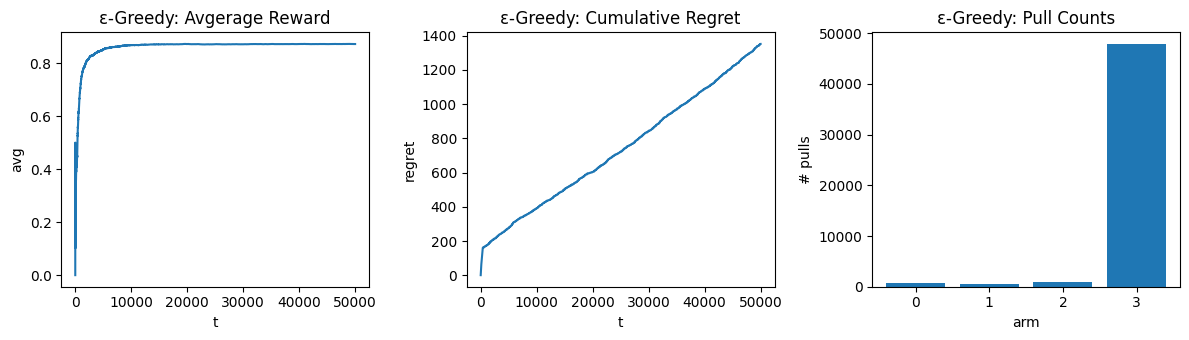

In [3]:
# Epsilon-Greedy — self-contained run function + quick test ========
import numpy as np
import matplotlib.pyplot as plt

def run_epsilon_greedy(probs, T, epsilon=0.1, seed=0):
    """
    Run epsilon-greedy for T steps on a BernoulliBandit with given probs.

    Returns:
        dict: {
          'rewards': np.array[T],
          'regrets': np.array[T],
          'actions': np.array[T],
          'Q': np.array[k],   # final value estimates
          'N': np.array[k],   # pull counts
        }
    """
    assert all(0.0 <= p <= 1.0 for p in probs), "All probabilities must be in [0, 1]"
    bandit = BernoulliBandit(probs)
    rng = np.random.default_rng(seed)

    k = len(probs)
    Q = np.zeros(k, dtype=float)   # value estimates
    N = np.zeros(k, dtype=int)     # pull counts

    rewards = np.zeros(T, dtype=int)
    regrets = np.zeros(T, dtype=float)
    actions = np.zeros(T, dtype=int)

    optimal_mean = float(np.max(probs))

    for t in range(1, T + 1):
        # ----------------------- TODO: ε-greedy selection ----------------------
        # With probability epsilon: choose a random arm.
        # Otherwise: choose the arm with the highest Q (break ties via np.argmax).
        #
        # Hint: rng.random() for the coin flip; rng.integers(0, k) for random arm.
        # Hint: np.argmax(Q) for exploitation.

        if rng.random() < epsilon:
            arm = rng.integers(0, k)   # explore with rng.integrers for random arm
        else:
            arm = int(np.argmax(Q))    # exploit with np.argmax for best estimated arm

        # ----------------------------------------------------------------------
        r = int(bandit.pull(arm))
        rewards[t - 1] = r
        actions[t - 1] = arm
        regrets[t - 1] = optimal_mean - probs[arm]

        N[arm] += 1
        Q[arm] += (r - Q[arm]) / N[arm]

    return {"rewards": rewards, "regrets": regrets, "actions": actions, "Q": Q, "N": N}

# --- Quick single-run test / visualization for ε-greedy ---

##############################################################
###
### You can play around with these parameters:
###
probs = [0.2, 0.1, 0.5, 0.9]    # true success probabilities of each arm 
T = 50000                        #number of pulls
epsilon = 0.05                  #exploration rate 
seed = 123
##############################################################

out_eps = run_epsilon_greedy(probs, T, epsilon, seed)

plt.figure(figsize=(12, 3.5))
plt.subplot(1, 3, 1)
avg_reward = np.cumsum(out_eps["rewards"]) / np.arange(1, T + 1)
plt.plot(avg_reward); plt.title("ε-Greedy: Avgerage Reward"); plt.xlabel("t"); plt.ylabel("avg")

plt.subplot(1, 3, 2)
plt.plot(np.cumsum(out_eps["regrets"])); plt.title("ε-Greedy: Cumulative Regret"); plt.xlabel("t"); plt.ylabel("regret")

plt.subplot(1, 3, 3)
counts = np.bincount(out_eps["actions"], minlength=len(probs))
plt.bar(range(len(probs)), counts); plt.title("ε-Greedy: Pull Counts"); plt.xlabel("arm"); plt.ylabel("# pulls")
plt.tight_layout(); plt.show()

**Average reward:**
- Starts low → early pulls include some exploration and initial Q=0
- Quickly rises → algorithm identifies the best arm (0.9)
- Plateaus near 0.9 → mostly exploiting the optimal arm

**Cumulative regret:** 
- Grows early → exploration causes some suboptimal pulls
- Continues to increase slowly → even 5% exploration contributes small regret over 50,000 pulls

**Pull counts:**
- Arm 3 (0.9) dominates → the algorithm correctly identifies the best arm
- Arms 0, 1, 2 have very few pulls → minimal exploration
- Most pulls go to the optimal arm → algorithm learned correctly

### Task 1 (b): UCB

Now implement **UCB** (Upper Confidence Bound) to learn the best arm. Follow the lab instructions.  
Below we provide starter code that can be used—**for the algorithm it is enough to change the marked text** (look for lines marked `TODO`).


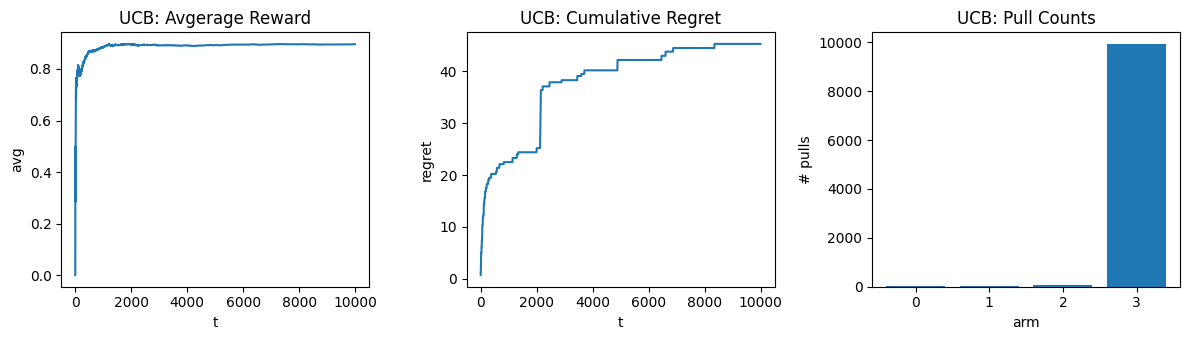

In [4]:
# UCB — self-contained run function + quick test ===================

def run_ucb(probs, T, c=1.0, seed=0):
    """
    Run Upper Confidence Bound (UCB) for T steps on a BernoulliBandit.

    Returns:
        dict: same structure as run_epsilon_greedy
    """
    assert all(0.0 <= p <= 1.0 for p in probs), "All probabilities must be in [0, 1]"
    bandit = BernoulliBandit(probs)
    rng = np.random.default_rng(seed)

    k = len(probs)
    Q = np.zeros(k, dtype=float)
    N = np.zeros(k, dtype=int)

    rewards = np.zeros(T, dtype=int)
    regrets = np.zeros(T, dtype=float)
    actions = np.zeros(T, dtype=int)

    optimal_mean = float(np.max(probs))

    for t in range(1, T + 1):
        # --------------------------- TODO: UCB selection -----------------------
        ucb_values = np.zeros(k) # Create array to hold UCB values for all arms

        for a in range(k): # Calculate UCB for each arm
            if N[a] == 0:
                ucb_values[a] = + np.inf # Ensure each arm is tried at least once
            else:
                ucb_values[a] = Q[a] + c * np.sqrt(np.log(t) / N[a]) # UCB formula

        arm = np.argmax(ucb_values) #Pick the arm with highest UCB

        # ----------------------------------------------------------------------

        r = int(bandit.pull(arm))
        rewards[t - 1] = r
        actions[t - 1] = arm
        regrets[t - 1] = optimal_mean - probs[arm]

        N[arm] += 1
        Q[arm] += (r - Q[arm]) / N[arm]

    return {"rewards": rewards, "regrets": regrets, "actions": actions, "Q": Q, "N": N}

# --- Quick single-run test / visualization for UCB ---

##############################################################
###
### You can play around with these parameters:
###
probs = [0.2, 0.1, 0.5, 0.9]
T = 10000
c=1.0
seed=123
##############################################################


out_ucb = run_ucb(probs, T, c, seed)

plt.figure(figsize=(12, 3.5))
plt.subplot(1, 3, 1)
avg_reward = np.cumsum(out_ucb["rewards"]) / np.arange(1, T + 1)
plt.plot(avg_reward); plt.title("UCB: Avgerage Reward"); plt.xlabel("t"); plt.ylabel("avg")

plt.subplot(1, 3, 2)
plt.plot(np.cumsum(out_ucb["regrets"])); plt.title("UCB: Cumulative Regret"); plt.xlabel("t"); plt.ylabel("regret")

plt.subplot(1, 3, 3)
counts = np.bincount(out_ucb["actions"], minlength=len(probs))
plt.bar(range(len(probs)), counts); plt.title("UCB: Pull Counts"); plt.xlabel("arm"); plt.ylabel("# pulls")
plt.tight_layout(); plt.show()


*Interpretation*

1. Average Reward quite quickly settles at 0.9 -> arm 3 gives a reward with probability 0.9
2. The cumulative regret plateaus at around 40 -> After initial exploration, UCB stops accumulating regret because it's consistently picking the optimal arm
3. Arm 3 gets constantly pulled as the best option. 

Difference to Epsilon Greedy:
- The ε (epsilon) parameter is fixed — it does not change over time -> Keeps exploring randomly, even if the best arm is found 
- The term \ln(t) grows slowly (logarithmic growth) -> So the uncertainty bonus increases very slowly — exploration decreases over time.

## Part 2: Contextual Bandits

### Part 2: Contextual Bandits

This part extends the bandit problem to include **contextual information** such as user preferences and age.

Below are three code cells corresponding to this part:

1. **Environment and Policies** – sets up the contextual bandit environment and the algorithms described in the lab instructions (Random, Contextual ε-Greedy, and LinUCB).  
2. **Long-Run Simulation** – runs all three algorithms and plots the **Average Reward** and **Cumulative Regret** over time, showing how each learns to recommend better articles.  
3. **Illustrative Simulation** – shows detailed examples of the first 6 interactions and, after 10,000 learning steps, how the recommendations have improved based on what each algorithm has learned.


In [ ]:
# === Cell 1: Environment and Policies =================================
import numpy as np

class ContextualNewsEnv:
    """
    Contextual bandit for news with interpretable features, incl. age.
    Reward ~ Bernoulli(sigmoid(theta[a] · x)).
    """
    def __init__(self, seed=0):
        self.rng = np.random.default_rng(seed)
        # 6 human-readable features (last one is age_z = (age - 40)/15)
        self.feature_names = [
            "likes_politics",
            "sports_fan",
            "techie",
            "mobile_user",
            "morning_reader",
            "age_z",             # standardized age (0 ≈ 40y, +1 ≈ 55y, -1 ≈ 25y)
        ]
        self.d = len(self.feature_names)
        self.arm_names = ["Politics", "Sports", "Tech", "Lifestyle"]
        self.k = len(self.arm_names)

        # True arm parameters (rows=arms, cols=features); include age effects
        self.theta = np.array([
            [ 1.6,  0.2,  0.1,  0.2,  0.7,  0.4],   # Politics prefers older & morning readers
            [ 0.1,  1.8,  0.1,  0.7,  0.2, -0.1],   # Sports slightly skew younger/mobile
            [ 0.0,  0.1,  1.9, -0.1, -0.2, -0.2],   # Tech slightly skew younger
            [ 0.3,  0.2,  0.2,  1.0,  0.8,  0.0],   # Lifestyle mostly device/time driven
        ], dtype=float)

    @staticmethod
    def _sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))

    def _sample_age_z(self):
        """
        Sample an age in years, then standardize:
            age_z = (age - 40) / 15
        (≈ N(40, 12^2) clipped to [18, 80] for realism)
        """
        age = float(np.clip(self.rng.normal(40, 12), 18, 80))
        return (age - 40.0) / 15.0

    def sample_context(self):
        """
        Sample an interpretable user:
        pick a coarse segment, then add noise; append standardized age.
        """
        seg = self.rng.choice(["politics", "sports", "tech", "on_the_go", "morning_person"]) #profile of users
        x = np.zeros(self.d)
        if seg == "politics":
            core = np.array([1.6, 0.2, 0.2, 0.3, 0.9])
        elif seg == "sports":
            core = np.array([0.2, 1.8, 0.2, 1.0, 0.3])
        elif seg == "tech":
            core = np.array([0.2, 0.2, 1.9, 0.3, 0.2])
        elif seg == "on_the_go":
            core = np.array([0.4, 0.9, 0.5, 1.8, 0.7])
        else:  # morning_person
            core = np.array([0.8, 0.3, 0.2, 0.6, 1.9])
        core = core + self.rng.normal(0, 0.2, size=5)
        age_z = self._sample_age_z()
        x[:5] = core
        x[5] = age_z
        return x

    def click_prob(self, arm, x):
        return float(self._sigmoid(self.theta[arm] @ x))

    def click(self, arm, x):
        """Return (reward, true_click_prob)."""
        p = self.click_prob(arm, x)
        r = int(self.rng.random() < p)
        return r, p


# ---- Policies ---------------------------------------------------------------
class Policy:
    def select(self, x: np.ndarray) -> int: raise NotImplementedError
    def update(self, arm: int, x: np.ndarray, r: int): pass

class RandomPolicy(Policy):
    def __init__(self, k, seed=0):
        self.k = k
        self.rng = np.random.default_rng(seed)
    def select(self, x): return int(self.rng.integers(0, self.k))

class ContextualEpsGreedy(Policy):
    """Linear model per arm; ε-greedy on θ̂_a · x with random tie-breaking."""
    def __init__(self, k, d, epsilon=0.1, seed=0):
        self.eps = float(epsilon)
        self.Q = np.zeros((k, d))
        self.N = np.zeros(k, dtype=int)
        self.rng = np.random.default_rng(seed)
    def select(self, x):
        if self.rng.random() < self.eps:
            return int(self.rng.integers(0, self.Q.shape[0]))
        scores = self.Q @ x
        best = np.flatnonzero(scores == np.max(scores))
        return int(self.rng.choice(best))
    def update(self, arm, x, r):
        self.N[arm] += 1
        pred = self.Q[arm] @ x
        self.Q[arm] += (r - pred) * x / self.N[arm]

class LinUCB(Policy):
    """Per-arm ridge regression + UCB: θ̂_a^T x + α sqrt(x^T A_a^{-1} x)."""
    def __init__(self, k, d, alpha=1.0, lambda_=1.0):
        self.k, self.d = k, d
        self.alpha = float(alpha)
        self.A = [lambda_ * np.eye(d) for _ in range(k)]
        self.b = [np.zeros(d) for _ in range(k)]
    def select(self, x):
        vals = np.empty(self.k)
        for a in range(self.k):
            A_inv_x = np.linalg.solve(self.A[a], x)
            theta_hat = np.linalg.solve(self.A[a], self.b[a])
            pred = theta_hat @ x
            bonus = self.alpha * np.sqrt(x @ A_inv_x)
            vals[a] = pred + bonus
        return int(np.argmax(vals))
    def update(self, arm, x, r):
        self.A[arm] += np.outer(x, x)
        self.b[arm] += r * x


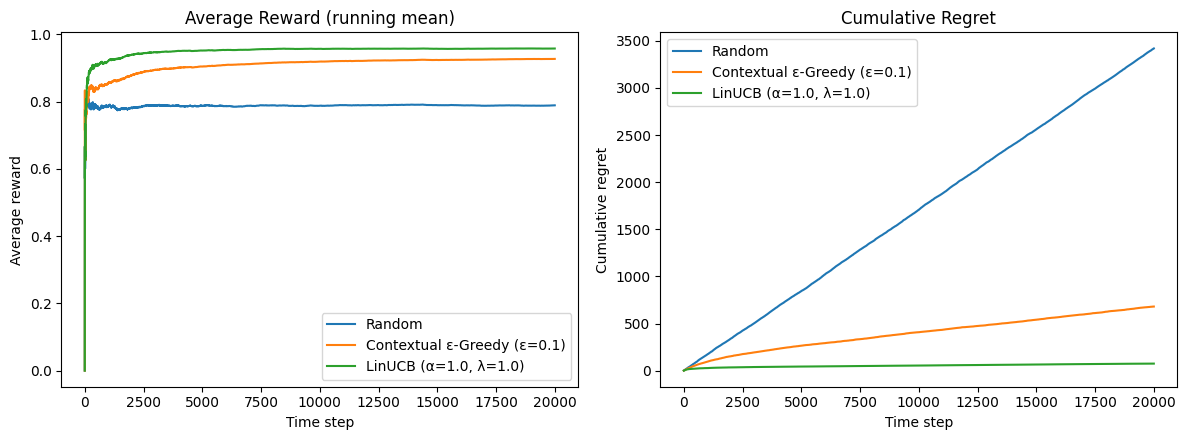

Totals over T steps
  Random:              reward=15775, final avg=0.789, cum regret=3419.8
  Contextual ε-Greedy: reward=18536, final avg=0.927, cum regret=680.2
  LinUCB:              reward=19154, final avg=0.958, cum regret=74.3


In [10]:
# === Cell 2: Long-run simulation with Average Reward & Cumulative Regret =====
import numpy as np
import matplotlib.pyplot as plt

# ---- Parameters you can play with -------------------------------------------
T = 20000         # horizon (longer run for clearer curves)
epsilon = 0.1     # contextual ε-greedy exploration rate
alpha = 1.0       # LinUCB exploration bonus
lambda_ = 1.0     # LinUCB regularization
seed = 10          # master seed for reproducibility

# ---- Generate one fixed context sequence (fair comparison across policies) ---
env_for_contexts = ContextualNewsEnv(seed=seed)
contexts = [env_for_contexts.sample_context() for _ in range(T)]

# ---- Helper to run a policy on the fixed context sequence -------------------
def run_on_contexts(policy, env_seed, contexts):
    env = ContextualNewsEnv(seed=env_seed)  # fresh env so θ and RNG are consistent
    rewards = np.zeros(len(contexts), dtype=int)
    inst_regret = np.zeros(len(contexts), dtype=float)
    for t, x in enumerate(contexts):
        arm = policy.select(x)
        r, p_sel = env.click(arm, x)
        rewards[t] = r
        # compute instantaneous regret in *expected* terms:
        # p*(x) - p_sel(x), where p*(x)=max_a sigmoid(θ_a · x)
        true_scores = env.theta @ x
        p_star = 1.0 / (1.0 + np.exp(-np.max(true_scores)))
        inst_regret[t] = p_star - p_sel
        policy.update(arm, x, r)
    return rewards, inst_regret

# ---- Run Random, Contextual ε-Greedy, LinUCB --------------------------------
rng = np.random.default_rng(seed)
k = ContextualNewsEnv(seed=seed).k
d = ContextualNewsEnv(seed=seed).d

rewards_rand, regret_rand = run_on_contexts(RandomPolicy(k, seed=seed), seed, contexts)
rewards_eps,  regret_eps  = run_on_contexts(ContextualEpsGreedy(k, d, epsilon, seed), seed, contexts)
rewards_ucb,  regret_ucb  = run_on_contexts(LinUCB(k, d, alpha=alpha, lambda_=lambda_), seed, contexts)

# ---- Curves: running average reward & cumulative regret ---------------------
avg_rand = np.cumsum(rewards_rand) / np.arange(1, T+1)
avg_eps  = np.cumsum(rewards_eps)  / np.arange(1, T+1)
avg_ucb  = np.cumsum(rewards_ucb)  / np.arange(1, T+1)

cumreg_rand = np.cumsum(regret_rand)
cumreg_eps  = np.cumsum(regret_eps)
cumreg_ucb  = np.cumsum(regret_ucb)

# ---- Plot -------------------------------------------------------------------
plt.figure(figsize=(12,4.5))

plt.subplot(1,2,1)
plt.plot(avg_rand, label="Random")
plt.plot(avg_eps,  label=f"Contextual ε-Greedy (ε={epsilon})")
plt.plot(avg_ucb,  label=f"LinUCB (α={alpha}, λ={lambda_})")
plt.title("Average Reward (running mean)")
plt.xlabel("Time step"); plt.ylabel("Average reward"); plt.legend()

plt.subplot(1,2,2)
plt.plot(cumreg_rand, label="Random")
plt.plot(cumreg_eps,  label=f"Contextual ε-Greedy (ε={epsilon})")
plt.plot(cumreg_ucb,  label=f"LinUCB (α={alpha}, λ={lambda_})")
plt.title("Cumulative Regret")
plt.xlabel("Time step"); plt.ylabel("Cumulative regret"); plt.legend()

plt.tight_layout()
plt.show()

# ---- Quick totals ------------------------------------------------------------
print("Totals over T steps")
print(f"  Random:              reward={rewards_rand.sum():5d}, final avg={avg_rand[-1]:.3f}, cum regret={cumreg_rand[-1]:.1f}")
print(f"  Contextual ε-Greedy: reward={rewards_eps.sum():5d}, final avg={avg_eps[-1]:.3f}, cum regret={cumreg_eps[-1]:.1f}")
print(f"  LinUCB:              reward={rewards_ucb.sum():5d}, final avg={avg_ucb[-1]:.3f}, cum regret={cumreg_ucb[-1]:.1f}")


### 1. How the context affects the choice of article
- Each user has a context (likes_politics, sports_fan, techie, etc.) that helps predict which article they will click.  
- Contextual algorithms (ε-Greedy with context and LinUCB) use these features to score each article, so different users can get different recommendations.  
- **Example:** If a user likes politics, the predicted probability for the Politics article goes up → algorithm chooses Politics.

### 2. How the two algorithms learn over time
- **Contextual ε-Greedy:**  
  Learns from clicks for each arm in each context. Most of the time it picks the arm with the highest predicted reward, but sometimes it explores randomly. Over time, it learns which articles work best, but it always keeps exploring a bit.  
- **LinUCB:**  
  Builds a model for each arm and adds a “bonus” when the algorithm is uncertain about an arm. This makes it explore more intelligently. It quickly focuses on promising articles while still checking uncertain ones.

### 3. How Contextual ε-Greedy and LinUCB use context differently
- **ε-Greedy:** Uses context to predict reward, but exploration is random (doesn’t depend on context).  
- **LinUCB:** Uses context to predict reward **and** to estimate uncertainty. It explores more where it is uncertain and the context suggests the article could be good.

### 4. Role of ε, α, and λ in exploration vs. exploitation
- **ε (epsilon):** Chance for random exploration in ε-Greedy. Higher ε → more random picks; lower ε → more exploitation.  
- **α (alpha, in LinUCB):** Controls how much the uncertainty bonus matters. Higher α → more exploration; lower α → more greedy.  
- **λ (lambda):** Regularization in LinUCB. Higher λ → safer, slower learning; lower λ → can overfit noise.

### 5. Why LinUCB usually learns faster
- Exploration is smart, not random.  
- Focuses on arms it is uncertain about and that could give high reward.  
- This makes learning faster and safer than random exploration.

### 6. Is the linear assumption accurate? Can we do better?
- Linear models are a simplification: real-world rewards aren’t always perfectly linear.  
- **Ways to improve:**  
  - Use richer features (interactions, embeddings)  
  - Kernelized UCB  
  - Non-linear models (neural networks, bootstrapped DQN, Bayesian NN)  
  - Generalized linear models (GLM-UCB) for Bernoulli rewards

1.	How the context affects the choice of article
	•	Context vector (likes_politics, sports_fan, techie, etc.) is mapped into predicted rewards for each arm.
	•	Contextual algorithms (ε-greedy with context and LinUCB) use those features to compute preference scores; thus different contexts change which arm looks best.
	•	Example: a high likes_politics raises predicted probability for Politics → algorithm chooses Politics for that user type.
	2.	How the two algorithms learn over time
	•	Contextual ε-Greedy: updates Q[a] estimates from observed clicks for context-action pairs (or a context-conditioned estimator). It exploits the best-known arm most of the time and picks randomly with prob ε. Over time Q estimates improve so exploitation improves, but random exploration persists.
	•	LinUCB: fits a linear model per arm (or a shared linear model) and adds an uncertainty bonus that decays with N[a]. It actively explores arms with high uncertainty and focuses exploration where expected payoff could be high. That targeted exploration yields faster, safer learning.
	3.	How Contextual ε-Greedy and LinUCB use context differently
	•	ε-Greedy: context is used to estimate expected reward(s) (could be via a model) but exploration is context-agnostic random (with probability ε).
	•	LinUCB: uses context to compute both predicted reward and the uncertainty of that prediction. Exploration is context-aware: if context makes an arm’s prediction uncertain and potentially high, UCB will prefer testing it.
	4.	Role of ϵ, α, and λ in balancing exploration/exploitation
	•	ϵ (epsilon): constant random exploration rate. Larger ϵ → more random pulls forever; smaller ϵ → faster exploitation but risk of missing good arms.
	•	α (alpha) in LinUCB: scales the uncertainty bonus (α * sqrt(ln t / N)). Larger α → more exploration (bigger confidence intervals); smaller → more exploitation.
	•	λ (lambda): regularization in the linear estimator; higher λ → more bias (safer, smaller variance) but possibly slower learning. Low λ can overfit noise.
	5.	Why LinUCB typically learns faster and explores more systematically
	•	Because exploration is driven by uncertainty estimates that depend on context and sample counts, not by blind randomness. It focuses trials where the model is uncertain and the context suggests there is high upside.
	6.	How accurate is the linearity assumption? Can we do better?
	•	Linearity is a simplifying assumption: in many real recommendation problems the reward function is not exactly linear in raw features → the model can be misspecified.
	•	Improvements: use richer features (interactions, embeddings), kernelized UCB, contextual bandits with non-linear function approximators (neural contextual bandits / bootstrapped DQN / Bayesian NN), or use generalized linear bandits (GLM-UCB) if rewards are Bernoulli.

In [7]:
# === Cell 3: Before vs After Learning from 10,000 Samples ====================
import numpy as np

# --- Helpers (pretty printing + per-step explanation) -------------------------
def _fmt_kv(names, values):
    return ", ".join(f"{n}={v:.2f}" for n, v in zip(names, values))

def _explain_step(env, policy, x, label, show_reason=True):
    arm_names = env.arm_names
    k = env.k

    # Reasoning for each policy (before selecting)
    reasoning = ""
    if show_reason:
        if isinstance(policy, ContextualEpsGreedy):
            scores = policy.Q @ x
            max_val = np.max(scores)
            best = np.flatnonzero(scores == max_val)
            reasoning = "scores: [" + ", ".join(f"{arm_names[a]}={scores[a]:.3f}" for a in range(k)) + "]"
            if len(best) > 1:
                reasoning += f" | tie among: {', '.join(arm_names[a] for a in best)}"
        elif isinstance(policy, LinUCB):
            parts = []
            for a in range(k):
                A_inv_x = np.linalg.solve(policy.A[a], x)
                theta_hat = np.linalg.solve(policy.A[a], policy.b[a])
                pred = float(theta_hat @ x)
                bonus = float(policy.alpha * np.sqrt(x @ A_inv_x))
                parts.append(f"{arm_names[a]}={pred:.3f}+{bonus:.3f}={pred+bonus:.3f}")
            reasoning = "pred+bonus=UCB: [" + ", ".join(parts) + "]"
        else:
            reasoning = "Random policy (no scoring)."

    # Select, observe, update
    arm = policy.select(x)
    r, p = env.click(arm, x)
    policy.update(arm, x, r)

    # Bayes-optimal (for teaching/inspection only)
    true_scores = env.theta @ x
    best_true = int(np.argmax(true_scores))
    p_best = 1.0 / (1.0 + np.exp(-true_scores[best_true]))

    print(f"[{label:<10}] picked={env.arm_names[arm]:10s} | p(click)={p:.2f} | "
          f"clicked? {'YES' if r==1 else 'no '} | true best={env.arm_names[best_true]} (p*={p_best:.2f})")
    if show_reason and reasoning:
        print(f"            {reasoning}")

def walkthrough_before_after_with_random(
    pre_steps=6, train_T=10000, post_steps=6,
    epsilon=0.1, alpha=1.0, lambda_=1.0, seed=7
):
    # 1) Fixed contexts for fair comparison (same for all policies & phases)
    ctx_gen = ContextualNewsEnv(seed=seed)
    pre_contexts   = [ctx_gen.sample_context() for _ in range(pre_steps)]
    train_contexts = [ctx_gen.sample_context() for _ in range(train_T)]
    post_contexts  = [ctx_gen.sample_context() for _ in range(post_steps)]

    # 2) Independent envs (same θ, since same seed) for each policy & phase
    env_rand_pre   = ContextualNewsEnv(seed=seed)
    env_eps_pre    = ContextualNewsEnv(seed=seed)
    env_ucb_pre    = ContextualNewsEnv(seed=seed)

    env_rand_post  = ContextualNewsEnv(seed=seed)
    env_eps_train  = ContextualNewsEnv(seed=seed)
    env_ucb_train  = ContextualNewsEnv(seed=seed)
    env_eps_post   = ContextualNewsEnv(seed=seed)
    env_ucb_post   = ContextualNewsEnv(seed=seed)

    # 3) Policies (Random has no learning; ε-Greedy & LinUCB start from scratch)
    rand_pre  = RandomPolicy(k=env_rand_pre.k, seed=seed)
    eps       = ContextualEpsGreedy(k=env_eps_pre.k, d=env_eps_pre.d, epsilon=epsilon, seed=seed)
    ucb       = LinUCB(k=env_ucb_pre.k, d=env_ucb_pre.d, alpha=alpha, lambda_=lambda_)

    # --- BEFORE LEARNING: first N steps --------------------------------------
    print("=== BEFORE LEARNING (first 6 steps) ===")
    for t, x in enumerate(pre_contexts, 1):
        print(f"\nStep {t} context: {_fmt_kv(env_eps_pre.feature_names, x)}")
        _explain_step(env_rand_pre, rand_pre, x, label="Random")
        _explain_step(env_eps_pre,  eps,     x, label="ε-Greedy")
        _explain_step(env_ucb_pre,  ucb,     x, label="LinUCB")

    # --- TRAIN: 10,000 online rounds for ε-Greedy and LinUCB -----------------
    for x in train_contexts:
        # ε-Greedy training
        arm = eps.select(x)
        r, _ = env_eps_train.click(arm, x)
        eps.update(arm, x, r)
        # LinUCB training
        arm = ucb.select(x)
        r, _ = env_ucb_train.click(arm, x)
        ucb.update(arm, x, r)

    # Fresh Random for post phase (still stateless, no training)
    rand_post = RandomPolicy(k=env_rand_post.k, seed=seed)

    # --- AFTER LEARNING FROM 10,000 SAMPLES: next N steps --------------------
    print("\n=== AFTER LEARNING FROM 10,000 SAMPLES (next 6 steps) ===")
    for t, x in enumerate(post_contexts, 1):
        print(f"\nStep {t} context: {_fmt_kv(env_eps_post.feature_names, x)}")
        _explain_step(env_rand_post, rand_post, x, label="Random")
        _explain_step(env_eps_post,  eps,       x, label="ε-Greedy")
        _explain_step(env_ucb_post,  ucb,       x, label="LinUCB")

# Run the demonstration
walkthrough_before_after_with_random(
    pre_steps=6, train_T=10000, post_steps=6,
    epsilon=0.1, alpha=1.0, lambda_=1.0, seed=7
)



=== BEFORE LEARNING (first 6 steps) ===

Step 1 context: likes_politics=0.86, sports_fan=0.25, techie=0.02, mobile_user=0.51, morning_reader=1.70, age_z=0.05
[Random    ] picked=Lifestyle  | p(click)=0.90 | clicked? YES | true best=Politics (p*=0.94)
            Random policy (no scoring).
[ε-Greedy  ] picked=Tech       | p(click)=0.42 | clicked? no  | true best=Politics (p*=0.94)
            scores: [Politics=0.000, Sports=0.000, Tech=0.000, Lifestyle=0.000] | tie among: Politics, Sports, Tech, Lifestyle
[LinUCB    ] picked=Politics   | p(click)=0.94 | clicked? YES | true best=Politics (p*=0.94)
            pred+bonus=UCB: [Politics=0.000+1.989=1.989, Sports=0.000+1.989=1.989, Tech=0.000+1.989=1.989, Lifestyle=0.000+1.989=1.989]

Step 2 context: likes_politics=0.67, sports_fan=0.80, techie=0.38, mobile_user=1.90, morning_reader=0.77, age_z=0.08
[Random    ] picked=Tech       | p(click)=0.61 | clicked? no  | true best=Sports (p*=0.95)
            Random policy (no scoring).
[ε-Greedy  

# Random Policy
**Behavior:**
- Ignores all context features (likes_politics, sports_fan, age, etc.).
- Picks arms completely at random.
- Does not learn from clicks at all.

**Examples:**
- Step 1 (new user) → picks Lifestyle instead of Politics.
- Step 2 → picks Tech instead of Sports.
- After learning → still random picks (sometimes lucky, sometimes not).

**Key takeaway:**
- Provides a baseline.
- Unreliable for first-time users or after many steps.

# Contextual ε-Greedy
**How it works**
- Maintains a simple model for each arm to predict expected reward for a given user based on their features.
- With probability ε, it picks a random arm to explore.
- Otherwise, it picks the arm with the highest predicted reward (exploitation).
- Updates the model for the chosen arm after observing whether the user clicked or not.

**Characteristics**
- Exploration is random: sometimes tries an arm even if it looks bad.
- Early on, before seeing many rewards, picks are almost random because the model hasn’t learned yet.
- Learns gradually from user clicks and starts favoring arms that perform well in similar contexts.

**Examples:**
- Step 1: All scores are zero → picks Tech randomly.
- Step 3: After observing some clicks, scores start to diverge → begins to favor arms that worked for similar users.
# LinUCB
**How it works**
- Keeps track of a simple model for each arm to predict how well it will do for a given user.
- Also keeps track of how uncertain it is about each arm.
- Chooses the arm that looks the best plus a bonus for uncertainty.
- Updates its model for the chosen arm after seeing whether the user clicked or not.

**Characteristics**
- Exploration is smart, not random: it tries arms it isn’t sure about.
- Even before seeing many users, it explores all options systematically.
- Learns quickly and usually picks the best content for new users.

**Examples:**
- Step 1: Picks Politics (the best arm) even before learning because uncertainty bonus encourages trying promising arms.
- Step 3: Continues to explore intelligently, choosing arms with high predicted reward or high uncertainty.